In [1]:
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 63.5 MB/s eta 0:00:00


In [101]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from rdkit import Chem
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import Crippen, Descriptors, MACCSkeys, GraphDescriptors, Lipinski, QED, rdMolDescriptors, Fragments, FragmentMatcher
from rdkit.Chem.MolStandardize import rdMolStandardize
import sklearn
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from statistics import mean
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from xgboost import XGBRegressor

**Dataset preparation**

In [109]:
data1 = pd.read_csv('B3DB_classification.tsv', sep='\t')

In [4]:
data1['SMILES'] = data1['SMILES'].apply(lambda smi: Chem.CanonSmiles(Chem.MolToSmiles(Chem.MolFromSmiles(smi))))

In [5]:
data1 = data1[['SMILES', 'logBB']]

In [6]:
data1 = data1.dropna()
data1 = data1.drop_duplicates()
data1 = data1[(data1['logBB']>= -5) & (data1['logBB'] <= 1.8)]

In [111]:
data2 = pd.read_csv('final_logBB_2967.csv')

In [8]:
data2.head()

,InchiKey,smiles,new_logBB,new_BBclass,canon_smiles
0,AABLHGPVOULICI-UHFFFAOYSA-N,CN1CCC24C3Oc5c(O)ccc(CC1C2(O)CCC3O)c45,NaN,1,CN1CCC23c4c5ccc(O)c4OC2C(O)CCC3(O)C1C5
1,AAOVKJBEBIDNHE-UHFFFAOYSA-N,c1c(Cl)ccc(c12)N(C)C(=O)CN=C2c3ccccc3,0.330807,1,CN1C(=O)CN=C(c2ccccc2)c2cc(Cl)ccc21
2,AAQOQKQBGPPFNS-UHFFFAOYSA-N,CC[N+](C)(C)CC=1C=CC=CC=1[Br],NaN,0,CC[N+](C)(C)Cc1ccccc1Br
3,AAXVEMMRQDVLJB-UHFFFAOYSA-N,CC34CC(O)C1(F)C(CCC2=CC(=O)CCC12C)C3CCC4(O)C(=...,NaN,1,CC12CCC(=O)C=C1CCC1C3CCC(O)(C(=O)CO)C3(C)CC(O)...
4,ABQYZRZVRIPTPI-UHFFFAOYSA-M,COn1cc(C(=O)[O-])c(=O)c2cc3c(cc21)OCO3,-0.920500,1,COn1cc(C(=O)[O-])c(=O)c2cc3c(cc21)OCO3


In [9]:
data2 = data2[['canon_smiles', 'new_logBB']]
data2 = data2.rename(columns={'canon_smiles':'SMILES', 'new_logBB':'logBB'})

In [10]:
data2 = data2.dropna()
data2 = data2.drop_duplicates()
data2 = data2[(data2['logBB']>= -5) & (data2['logBB'] <= 1.8)]

In [11]:
df = pd.concat([data1, data2])

In [12]:
df = df.drop_duplicates(subset=['SMILES'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1373 entries, 0 to 2965
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SMILES  1373 non-null   object 
 1   logBB   1373 non-null   float64
dtypes: float64(1), object(1)
memory usage: 32.2+ KB


In [14]:
un = rdMolStandardize.Uncharger()

In [15]:
df['Agglomeration'] = df['SMILES'].apply(lambda x: '.' in x)
df['SMILES_clear'] = df['SMILES'].apply(lambda x: max(x.split('.'), key=len))
df['ROMol'] = df['SMILES_clear'].apply(lambda x: Chem.MolFromSmiles(x))
df.shape

(1373, 5)

In [16]:
df = df[~df["ROMol"].isna()]
df.shape

(1373, 5)

In [17]:
df['FORMAL_CHARGE_ch'] = df['SMILES_clear'].apply(lambda x: Chem.GetFormalCharge(Chem.MolFromSmiles(x)))
df['SMILES_uncharge'] = df['ROMol'].apply(lambda x: Chem.MolToSmiles(un.uncharge(x), kekuleSmiles=True))
df['FORMAL_CHARGE_unch'] = df['SMILES_uncharge'].apply(lambda x: Chem.GetFormalCharge(Chem.MolFromSmiles(x)))

[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Running Uncharger
[06:01:42] Run

In [18]:
df.drop(labels=['SMILES_clear', 'ROMol', 'FORMAL_CHARGE_ch'], inplace=True, axis=1)

In [19]:
df.reset_index(drop=True, inplace=True)

In [20]:
sm = df['SMILES_uncharge'].values
index_sm = df.index.tolist()

In [21]:
list_inorg_el = ['Al', 'Au', 'Ar,''Ba', 'Be', 'Bi', 'Ca','Cd', 'Co','Cr','Cu','Fe', 'Gd','Ge', 'Hf',
                 'Hg', 'In', 'K', 'Kr' 'La', 'Mg', 'Mn', 'Na', 'Ni', 'Pb', 'Pt', 'Sb', 'Sn','Sr','Te',
                 'V','Zn', 'Li', 'Xe', 'Rn', 'Ne']
index_drop = [] # find and delete inorganic compounds
uniq_el = set([])
for sm_i in range(len(sm)):
    mol_sm = Chem.MolFromSmiles(sm[sm_i])
    list_at = [str(x.GetSymbol()) for x in mol_sm.GetAtoms()]
    intersec = list(set(list_at) & set(list_inorg_el))
    T_C = 'C' in list_at
    if T_C == False:
        index_drop.append(index_sm[sm_i])
        print('smiles', sm[sm_i])
    elif len(intersec) > 0:
        index_drop.append(index_sm[sm_i])
        print('intersection', intersec)
    uniq_el = uniq_el | set(list_at)

smiles [Li]
smiles [Kr]
smiles O
smiles N#N
smiles [Ar]
smiles [N-]=[N+]=O
smiles N#[N+]O
smiles NN
smiles [Xe]
smiles [Ne]
smiles FS(F)(F)(F)(F)F
smiles N#[N+][O-]
smiles [Rn]


In [22]:
len(index_drop)

13

In [23]:
df.drop(index=index_drop, inplace=True)

In [24]:
df.drop_duplicates(subset=['SMILES_uncharge'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1178 entries, 0 to 1370
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SMILES              1178 non-null   object 
 1   logBB               1178 non-null   float64
 2   Agglomeration       1178 non-null   bool   
 3   SMILES_uncharge     1178 non-null   object 
 4   FORMAL_CHARGE_unch  1178 non-null   int64  
dtypes: bool(1), float64(1), int64(1), object(2)
memory usage: 47.2+ KB


In [25]:
df = df[['SMILES_uncharge', 'logBB']]

In [26]:
df = df.rename(columns={'SMILES_uncharge':'SMILES'})
df.head()

,SMILES,logBB
0,O=C(O)C1=CC(N=NC2=CC=C(S(=O)(=O)NC3=CC=CC=N3)C...,-2.69
1,COC1(NC(=O)C(C(=O)O)C2=CC=C(O)C=C2)C(=O)N2C(C(...,-2.52
2,OC1=C(I)C=C(Cl)C2=CC=CN=C12,-2.40
3,CCNC(=NCCSCC1=NC=CC=C1Br)NC#N,-2.15
4,CN1CC[C@]23C4=C5C=CC(OC6O[C@H](C(=O)O)[C@@H](O...,-2.15


In [27]:
mean_logBB = df['logBB'].mean()
mean_logBB

-0.11057294322835315

In [28]:
std_logBB = df['logBB'].std()
std_logBB

0.761311522408681

In [29]:
df = df[(df['logBB'] < (mean_logBB + 2 * std_logBB)) & (df['logBB'] > (mean_logBB - 2 * std_logBB))]
df.shape

(1130, 2)

**Features generation**

QED and Crippen modules

<ipython-input-30-7dbeb197253d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.at[i, 'MW'] = round(qed_vector[0], 2)
<ipython-input-30-7dbeb197253d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.at[i, 'AlogP'] = round(qed_vector[1], 2)
<ipython-input-30-7dbeb197253d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

<Axes: >

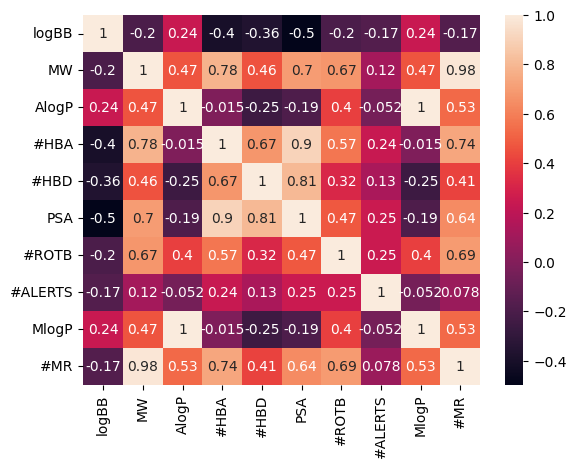

In [30]:
for i, row in df.iterrows():
    mol = Chem.MolFromSmiles(row.SMILES)
    qed_vector = QED.properties(mol)
    df.at[i, 'MW'] = round(qed_vector[0], 2)
    df.at[i, 'AlogP'] = round(qed_vector[1], 2)
    df.at[i, '#HBA'] = qed_vector[2]
    df.at[i, '#HBD'] = qed_vector[3]
    df.at[i, 'PSA'] = qed_vector[4]
    df.at[i, '#ROTB'] = qed_vector[5]
    df.at[i, '#ALERTS'] = qed_vector[7]

    df.at[i, 'MlogP'] = round(Crippen.MolLogP(mol), 2)
    df.at[i, '#MR'] = round(Crippen.MolMR(mol), 2)

df1 = df.loc[:, 'logBB'::]
sns.heatmap(df1.corr(), annot=True)

In [31]:
df = df.drop(labels=['AlogP', '#MR'], axis=1)

Lipinski module

<Axes: >

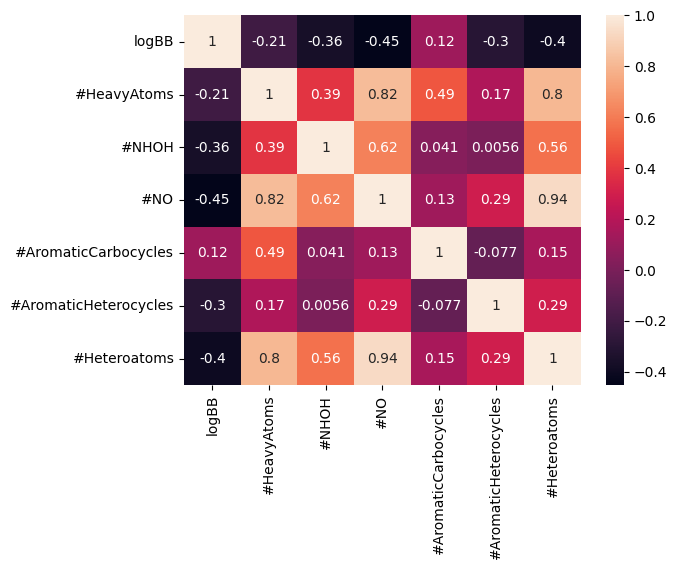

In [32]:
for i, row in df.iterrows():
    mol = Chem.MolFromSmiles(row.SMILES)
    df.at[i, '#HeavyAtoms'] = Lipinski.HeavyAtomCount(mol)
    df.at[i, '#NHOH'] = Lipinski.NHOHCount(mol)
    df.at[i, '#NO'] = Lipinski.NOCount(mol)
    df.at[i, '#AromaticCarbocycles'] = Lipinski.NumAromaticCarbocycles(mol)
    df.at[i, '#AromaticHeterocycles'] = Lipinski.NumAromaticHeterocycles(mol)
    df.at[i, '#Heteroatoms'] = Lipinski.NumHeteroatoms(mol)
df1 = df[['logBB', '#HeavyAtoms', '#NHOH', '#NO', '#AromaticCarbocycles', '#AromaticHeterocycles', '#Heteroatoms']]
sns.heatmap(df1.corr(), annot=True)

In [33]:
del df['#Heteroatoms']

**Descriptors module**

<Axes: >

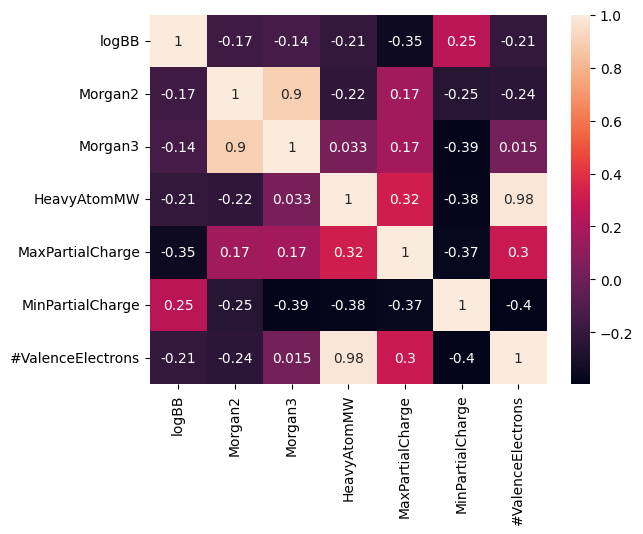

In [34]:
for i, row in df.iterrows():
    mol = Chem.MolFromSmiles(row.SMILES)
    df.at[i, 'Morgan2'] =  round(Descriptors.FpDensityMorgan2(mol), 2)
    df.at[i, 'Morgan3'] =  round(Descriptors.FpDensityMorgan3(mol), 2)
    df.at[i, 'HeavyAtomMW'] =  round(Descriptors.HeavyAtomMolWt(mol), 2)
    df.at[i, 'MaxPartialCharge'] = Descriptors.MaxPartialCharge(mol)
    df.at[i, 'MinPartialCharge'] = Descriptors.MinPartialCharge(mol)
    df.at[i, '#ValenceElectrons'] = Descriptors.NumValenceElectrons(mol)

df1 = df[['logBB', 'Morgan2', 'Morgan3', 'HeavyAtomMW', 'MaxPartialCharge', 'MinPartialCharge', '#ValenceElectrons']]
sns.heatmap(df1.corr(), annot=True)

In [35]:
df = df.drop(labels=['HeavyAtomMW', 'Morgan3'], axis=1) # Morgan3 is quite similar to Morgan2, better to delete

**GraphDescriptors module**

<Axes: >

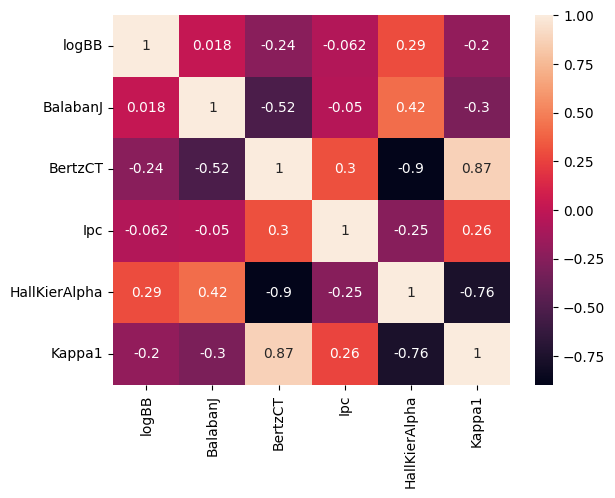

In [36]:
for i, row in df.iterrows():
    mol = Chem.MolFromSmiles(row.SMILES)
    df.at[i, 'BalabanJ'] = round(GraphDescriptors.BalabanJ(mol), 2)
    df.at[i, 'BertzCT'] = round(GraphDescriptors.BertzCT(mol), 2)
    df.at[i, 'Ipc'] = round(GraphDescriptors.Ipc(mol), 2)
    df.at[i, 'HallKierAlpha'] = round(GraphDescriptors.HallKierAlpha(mol), 2)
    df.at[i, 'Kappa1']  = round(GraphDescriptors.Kappa1(mol), 2)
df1 = df[['logBB', 'BalabanJ', 'BertzCT', 'Ipc', 'HallKierAlpha', 'Kappa1']]
#df1 = df1.drop(['AlogP', '', ], axis=1)
sns.heatmap(df1.corr(), annot=True)

In [37]:
df.head()

,SMILES,logBB,MW,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#HeavyAtoms,...,#AromaticHeterocycles,Morgan2,MaxPartialCharge,MinPartialCharge,#ValenceElectrons,BalabanJ,BertzCT,Ipc,HallKierAlpha,Kappa1
29,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,-1.60,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,12.0,...,0.0,0.92,0.110579,-0.393579,74.0,3.99,104.61,358.75,-0.24,11.76
30,OCC(O)C(O)C(O)C(O)CO,-1.60,182.17,6.0,6.0,121.38,5.0,0.0,-3.59,12.0,...,0.0,0.92,0.110579,-0.393579,74.0,3.99,104.61,358.75,-0.24,11.76
31,CC(=O)NC1=CC=CC(C2=CSC(N=C(N)N)=N2)=C1,-1.57,275.34,4.0,3.0,106.39,3.0,2.0,1.67,19.0,...,1.0,2.21,0.220748,-0.369771,98.0,2.29,630.55,22155.36,-2.41,13.03
32,O=C(O)C1=NC2=CC=C(C(F)(F)F)C=C2N=C1NCC1=CC=C(C...,-1.57,415.29,5.0,2.0,75.11,4.0,1.0,4.98,29.0,...,1.0,1.45,0.415990,-0.476407,152.0,1.92,1062.11,1782927.89,-3.37,20.37
33,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,-1.54,543.48,17.0,8.0,285.14,9.0,1.0,-5.60,34.0,...,0.0,1.35,0.396945,-0.387946,200.0,2.27,911.18,8843207.70,-1.11,29.12


In [38]:
corr_matrix = df.corr()
col_index_to_del = []

<ipython-input-38-66b2a69e0330>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


In [39]:
for i in range(2, corr_matrix.shape[0]):
    for j in range(2, i):
        if abs(round(corr_matrix.iloc[i][j], 2)) >= 0.9:
            if (i not in col_index_to_del) and (j not in col_index_to_del):
                if corr_matrix.iloc[i][0] >= corr_matrix.iloc[j][0]:
                    col_index_to_del.append(j)
                else:
                    col_index_to_del.append(i)

In [40]:
print(col_index_to_del)

[4, 9, 10, 16, 18, 8]


In [41]:
df.drop(df.columns[col_index_to_del], axis=1, inplace=True)
df.head()

,SMILES,logBB,MW,#HBA,PSA,#ROTB,#ALERTS,#NO,#AromaticCarbocycles,#AromaticHeterocycles,Morgan2,MaxPartialCharge,#ValenceElectrons,BertzCT,Ipc,HallKierAlpha,Kappa1
29,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,-1.60,182.17,6.0,121.38,5.0,0.0,6.0,0.0,0.0,0.92,0.110579,74.0,104.61,358.75,-0.24,11.76
30,OCC(O)C(O)C(O)C(O)CO,-1.60,182.17,6.0,121.38,5.0,0.0,6.0,0.0,0.0,0.92,0.110579,74.0,104.61,358.75,-0.24,11.76
31,CC(=O)NC1=CC=CC(C2=CSC(N=C(N)N)=N2)=C1,-1.57,275.34,4.0,106.39,3.0,2.0,6.0,1.0,1.0,2.21,0.220748,98.0,630.55,22155.36,-2.41,13.03
32,O=C(O)C1=NC2=CC=C(C(F)(F)F)C=C2N=C1NCC1=CC=C(C...,-1.57,415.29,5.0,75.11,4.0,1.0,5.0,2.0,1.0,1.45,0.415990,152.0,1062.11,1782927.89,-3.37,20.37
33,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,-1.54,543.48,17.0,285.14,9.0,1.0,18.0,0.0,0.0,1.35,0.396945,200.0,911.18,8843207.70,-1.11,29.12


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1130 entries, 29 to 1370
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SMILES                 1130 non-null   object 
 1   logBB                  1130 non-null   float64
 2   MW                     1130 non-null   float64
 3   #HBA                   1130 non-null   float64
 4   PSA                    1130 non-null   float64
 5   #ROTB                  1130 non-null   float64
 6   #ALERTS                1130 non-null   float64
 7   #NO                    1130 non-null   float64
 8   #AromaticCarbocycles   1130 non-null   float64
 9   #AromaticHeterocycles  1130 non-null   float64
 10  Morgan2                1130 non-null   float64
 11  MaxPartialCharge       1130 non-null   float64
 12  #ValenceElectrons      1130 non-null   float64
 13  BertzCT                1130 non-null   float64
 14  Ipc                    1130 non-null   float64
 15  Hal

**Avalon fingerprints**

In [43]:
def generate_AVfpts(data):
    Avalon_fpts = []
    mols = [Chem.MolFromSmiles(x) for x in data if x is not None]
    for mol in tqdm(mols):
        avfpts = pyAvalonTools.GetAvalonFP(mol, nBits=512)
        Avalon_fpts.append(avfpts)
    return np.array(Avalon_fpts)

In [44]:
Avalon_fpts = generate_AVfpts(df['SMILES'])

100%|██████████| 1130/1130 [00:00<00:00, 1360.62it/s]


In [45]:
df.reset_index(drop=True, inplace=True)

In [46]:
for i, row in df.iterrows():
    for j in range(Avalon_fpts.shape[1]):
        df.at[i, f'A_{j+1}'] = Avalon_fpts[i][j]

df.head()

<ipython-input-46-7ed5c3b00665>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[i, f'A_{j+1}'] = Avalon_fpts[i][j]
<ipython-input-46-7ed5c3b00665>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[i, f'A_{j+1}'] = Avalon_fpts[i][j]
<ipython-input-46-7ed5c3b00665>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `new

,SMILES,logBB,MW,#HBA,PSA,#ROTB,#ALERTS,#NO,#AromaticCarbocycles,#AromaticHeterocycles,...,A_503,A_504,A_505,A_506,A_507,A_508,A_509,A_510,A_511,A_512
0,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,-1.60,182.17,6.0,121.38,5.0,0.0,6.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,OCC(O)C(O)C(O)C(O)CO,-1.60,182.17,6.0,121.38,5.0,0.0,6.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CC(=O)NC1=CC=CC(C2=CSC(N=C(N)N)=N2)=C1,-1.57,275.34,4.0,106.39,3.0,2.0,6.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
3,O=C(O)C1=NC2=CC=C(C(F)(F)F)C=C2N=C1NCC1=CC=C(C...,-1.57,415.29,5.0,75.11,4.0,1.0,5.0,2.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
4,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,-1.54,543.48,17.0,285.14,9.0,1.0,18.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [47]:
del df['SMILES']

**Feature selection**

In [48]:
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_regression, k=396)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [49]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [50]:
X_train, X_test, y_train, y_test = X, X, y, y

In [51]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [52]:
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

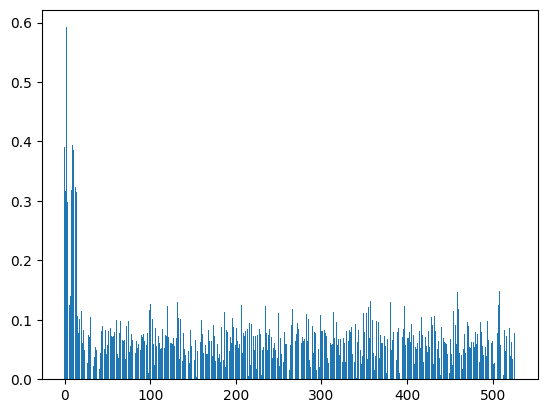

In [53]:
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [54]:
cols_idxs = fs.get_support(indices=True)
features_df_new = df.iloc[:,cols_idxs]
selected_features = list(features_df_new.columns)
len(selected_features)

396

In [55]:
df = df[selected_features]
df.head()

,logBB,MW,#HBA,PSA,#ROTB,#ALERTS,#NO,#AromaticCarbocycles,#AromaticHeterocycles,Morgan2,...,A_494,A_496,A_499,A_501,A_502,A_504,A_505,A_507,A_510,A_511
0,-1.60,182.17,6.0,121.38,5.0,0.0,6.0,0.0,0.0,0.92,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.60,182.17,6.0,121.38,5.0,0.0,6.0,0.0,0.0,0.92,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.57,275.34,4.0,106.39,3.0,2.0,6.0,1.0,1.0,2.21,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,-1.57,415.29,5.0,75.11,4.0,1.0,5.0,2.0,1.0,1.45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-1.54,543.48,17.0,285.14,9.0,1.0,18.0,0.0,0.0,1.35,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


### **Training preparation**

In [56]:
split = KFold(n_splits=5, random_state=41, shuffle=True)
scores= {
         "Q2": "r2",
         "MSE": make_scorer(mean_squared_error, squared=False)
         }

In [57]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [58]:
X_train, X_test, y_train, y_test = X, X, y, y

In [59]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### **5-fold CV**

In [60]:
def cv(model):
  cv_scores = cross_validate(model, X_train, y_train, scoring=scores, cv=split)
  print(f"On cross-validation:")
  print(f"Mean RMSE score is {cv_scores['test_MSE'].mean().round(3)} ± {cv_scores['test_MSE'].std().round(3)}")
  print(f"Mean Q2 score is {cv_scores['test_Q2'].mean().round(3)} ± {cv_scores['test_Q2'].std().round(3)}")

In [94]:
rng = np.random.RandomState(0) # random state fixed

###**LinearRegression**

In [103]:
LR_model = LinearRegression()

In [104]:
cv(LR_model)

On cross-validation:
Mean RMSE score is 0.632 ± 0.055
Mean Q2 score is 0.127 ± 0.121


In [105]:
LR_model.fit(X_train, y_train)
y_pred = LR_model.predict(X_test)

print(f"R2: {r2_score(y_test, y_pred).round(3)}")

R2: 0.777


In [107]:
sns.set_theme()

<Axes: >

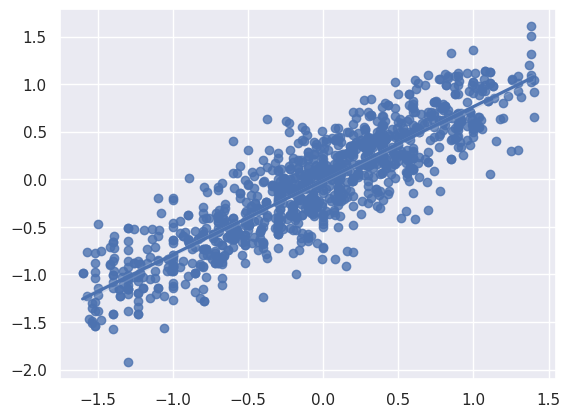

In [108]:
sns.regplot(x=y, y=y_pred)

### **GridSearch**

In [64]:
def do_grid_search(model, parameters):
  scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False) # определим RMSE как метрику оценки
  grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring=scorer, cv=5)
  grid_search.fit(X_train, y_train)# выполним поиск по сетке
  return grid_search.best_params_


### **LassoRegression**

In [65]:
lasso_model = Lasso()

In [66]:
lasso_parameters = {
    'alpha': [0.01, 0.1, 1, 5],
    'fit_intercept': [True, False],
    'positive': [True, False],
    'max_iter': [500, 1000, 1500],
    'warm_start': [True, False]
}

In [67]:
do_grid_search(lasso_model, lasso_parameters)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.902e-02, tolerance: 4.525e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.902e-02, tolerance: 4.525e-02
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.01,
 'fit_intercept': False,
 'max_iter': 500,
 'positive': False,
 'warm_start': True}

In [68]:
lasso_model = Lasso(alpha=0.01, fit_intercept=False, max_iter=500, positive=False, warm_start=True) # optimal parameters found

In [69]:
cv(lasso_model)

On cross-validation:
Mean RMSE score is 0.5 ± 0.014
Mean Q2 score is 0.452 ± 0.032


In [70]:
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)

print(f"R2: {r2_score(y_test, y_pred).round(3)}")

R2: 0.612


### **Ridge**

In [71]:
ridge_model = Ridge()

In [72]:
ridge_parameters = {
    'alpha': [0.01, 0.1, 1, 5],
    'fit_intercept': [True, False],
    'positive': [True, False],
    'max_iter': [500, 1000, 1500],
    'solver': ['auto', 'lsqr', 'svd', 'cholesky']
}

In [73]:
do_grid_search(ridge_model, ridge_parameters)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
360 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py", line 1134, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py", line 832, in fit
    raise ValueError(
ValueError: solver='lsqr' does not s

{'alpha': 5,
 'fit_intercept': False,
 'max_iter': 500,
 'positive': True,
 'solver': 'auto'}

In [74]:
ridge_model = Ridge(alpha=5, solver='auto', fit_intercept=False, max_iter=500, positive=True)

In [75]:
cv(ridge_model)

On cross-validation:
Mean RMSE score is 0.596 ± 0.021
Mean Q2 score is 0.222 ± 0.078


In [84]:
ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)

print(f"R2: {r2_score(y_test, y_pred).round(3)}")

R2: 0.256


### **SVM**

In [76]:
svm_model = SVR()

In [77]:
svm_parameters = {
    'degree': [2, 3, 5, 7],
    'kernel': ['rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'C': [1.0, 5.0, 10.0]
}

In [78]:
do_grid_search(svm_model, svm_parameters)

{'C': 10.0, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}

In [79]:
svm_model = SVR(degree=2, kernel='rbf', gamma='auto', C=10)

In [80]:
cv(svm_model)

On cross-validation:
Mean RMSE score is 0.418 ± 0.022
Mean Q2 score is 0.617 ± 0.037


In [86]:
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

print(f"R2: {r2_score(y_test, y_pred).round(3)}")

R2: 0.968


### **XGBoost**

In [88]:
xgb_model = XGBRegressor(seed=42, tree_method='gpu_hist', gpu_id=0)

In [89]:
xgb_parameters = {
    'max_depth': [6, 8, 10],
    'n_estimators': [1000, 1500, 2000],
    'subsample':[1, 0.75, 0.5],
    'min_samples_split':[2, 4]

}

In [90]:
do_grid_search(xgb_model, xgb_parameters)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:09:47] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:09:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:09:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:09:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU t

{'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 2000, 'subsample': 1}

In [92]:
xgb_model = XGBRegressor(seed=42, max_depth=6, min_samples_split=2, n_estimators=2000, subsample=1, tree_method='gpu_hist', gpu_id=0)

In [98]:
cv(xgb_model)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:37:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:37:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:37:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:37:08] WARNING: /workspace/src/common/

On cross-validation:
Mean RMSE score is 0.41 ± 0.028
Mean Q2 score is 0.631 ± 0.053


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:37:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [99]:
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

print(f"R2: {r2_score(y_test, y_pred).round(3)}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:39:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:39:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


R2: 0.991


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:39:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


### **ANN**

In [102]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
# dataset class to supply data for NN
class logBBDataset(torch.utils.data.Dataset):

  def __init__(self, X, y):
    if not torch.is_tensor(X) and not torch.is_tensor(y):
      self.X = torch.tensor(X, dtype=torch.float32)
      self.y = torch.tensor(y, dtype=torch.float32)

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]

In [ ]:
# class trainer allows to train model and save learning history as well as best parameters
class Trainer:
    def __init__(self, model, epochs, criterion,
                 optimizer, trainloader,
                 validloader, device, metric,
                 validate=True, scheduler=None,
                 verbose=2):
        self.model = model.to(device)
        self.epochs = epochs
        self.criterion = criterion
        self.optimizer = optimizer
        self.trainloader = trainloader
        self.validloader = validloader
        self.device = device
        self.metric = metric
        self.validate = validate
        self.verbose = verbose
        self.scheduler = scheduler

        # learning history
        self.train_mse_losses = []
        self.valid_mse_losses = []

        self.train_r2_metrics = []
        self.valid_r2_metrics = []

        # save best [(MSE, R2) on train, (MSE, R2) on validation]
        self.best_metrics = [(0, 0), (0, 0)]

    def fit(self, epochs=None):
        if epochs is None: # if no new epocks are passed use value at initiation
            epochs = self.epochs

        for epoch in range(epochs):
            train_loss, train_metric = self._train(self.trainloader) # train net

            # save metric and loss
            self.train_mse_losses.append(train_loss)
            self.train_r2_metrics.append(train_metric)

            # validate the net
            if self.validate:
              val_loss, val_metric = self._validate(self.validloader)
              self.valid_mse_losses.append(val_loss)
              self.valid_r2_metrics.append(val_metric)

              # in case we use sheduler update it
              if self.scheduler is not None:
                  self.scheduler.step(val_loss)
            else:
              val_loss = "NO"

            # check and update best metrics based on R2
            if (self.best_metrics[0][1] < train_metric) and (self.best_metrics[1][1] < val_metric):
              self.best_metrics = [(train_loss, train_metric), (val_loss, val_metric)]

            if self.verbose > 0:
              print()
              print(f"Epoch {epoch+1} out of {epochs}: Train loss = {train_loss}, validation loss = {val_loss} \n\
                                        Train metric = {train_metric}, validation metric = {val_metric}")
              print()

        return self

    def _train(self, loader):
        self.model.train() # train state
        epoch_loss, n_samples = 0, 0
        epoch_preds = []
        epoch_targets = []
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(self.device), targets.to(self.device) # move data to device
            n = targets.shape[0]
            n_samples += n
            targets = targets.view(targets.shape[0],1) # reshape targets to match net output
            out = self.model(inputs) # get predictions
            loss = torch.sqrt(self.criterion(out, targets)) #calculate loss
            epoch_loss += loss.item() * n # accumulate loss
            self.optimizer.zero_grad()
            loss.backward() # back propagation

            if self.verbose > 1:
                print(f"\rTraining: batch {i+1} out of {len(loader)}", end="")

            self.optimizer.step() # change weights

            # get predictions and target values from this epoch
            epoch_preds += list(out.detach().cpu().numpy())
            epoch_targets += list(targets.detach().cpu().numpy())

            self._clear_vram(inputs, targets, out) # clear RAM

        epoch_loss = epoch_loss/n_samples # calculate overall loss
        epoch_metric = self.metric(epoch_targets, epoch_preds) # get train metric
        if self.verbose > 1:
          print("\n", end="")

        return epoch_loss, epoch_metric

    def _validate(self, loader):
        self.model.eval() # eval state
        epoch_loss, n_samples = 0, 0
        epoch_preds = []
        epoch_targets = []
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(loader):
                inputs, targets = inputs.to(self.device), targets.to(self.device) # move data to evice
                n = targets.shape[0]
                n_samples += n
                targets = targets.view(targets.shape[0],1) # reshape targets to match net output
                out = self.model(inputs) # get logits
                loss = torch.sqrt(self.criterion(out, targets)) # get loss

                if self.verbose > 1:
                    print(f"\rValidation: batch {i+1} out of {len(loader)}", end="")

                epoch_loss += loss.item() * n # accumulate loss

                epoch_preds += list(out.detach().cpu().numpy())
                epoch_targets += list(targets.detach().cpu().numpy())

                self._clear_vram(inputs, targets, out) # clear RAM

        epoch_loss = epoch_loss/n_samples # get validation loss
        epoch_metric = self.metric(epoch_targets, epoch_preds) # get validation metric
        if self.verbose > 1:
          print("\n", end="")

        return epoch_loss, epoch_metric

    def _clear_vram(self, inputs, labels, outputs): # method to clear ram
        inputs = inputs.to("cpu")
        labels = labels.to("cpu")
        outputs = outputs.to("cpu")
        del inputs, labels, outputs
        torch.cuda.empty_cache()

In [ ]:
class logBB_Net(nn.Module):
    def __init__(self, n_input_features, n_input_layer, n_inner_layer):
        super().__init__()

        self.regressor = nn.Sequential(
            nn.Linear(in_features=n_input_features, out_features=n_input_layer),
            # nn.Dropout(0.1),
            nn.LeakyReLU(),

            nn.Linear(in_features=n_input_layer, out_features=n_inner_layer),
            # nn.Dropout(0.1),
            nn.LeakyReLU(),
            nn.Linear(in_features=n_input_layer, out_features=n_inner_layer),
            # nn.Dropout(0.1),
            nn.LeakyReLU(),
             nn.Linear(in_features=n_input_layer, out_features=n_inner_layer),
            # nn.Dropout(0.1),
            nn.LeakyReLU(),

            nn.Linear(in_features=n_inner_layer, out_features=1)
        )

    def forward(self, x):
      return self.regressor(x)

#### **Hyperparameters net**                                                   
*optimizer*: [Adam, Nadam,Adadelta],                            
*activation function*: [ReLU, SELU, LeakyReLU],                                  
*hidden layers*: [1, 2, 3, 4, 5, 6],
*epochs*: [80, 100, 150, 200],                                     
*dropout rate*: [0, 0.1, 0.2, 0.5],                               *learning rate*: [ 0.00001, 0.0001, 0.0003, 0.001, 0.01, 0.1, 1],                                                             *features rate***: [1, 0.83, 0.75]                                      
** the percentage of  features sent to hidden layers

In [ ]:
# initiate model
def initiate_model():
  logBB_net = logBB_Net(n_input_features=395, n_input_layer=328, n_inner_layer=328)

  # define some other parameters
  n_epochs = 100
  criterion = nn.MSELoss() # criterion for training
  optimizer = torch.optim.Adam(logBB_net.parameters(), lr=3e-4) # define optimizer with lr
  return logBB_net, n_epochs, criterion, optimizer





In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=41)

In [ ]:
q2_scores = []
rmse_scores = []

Best scores achieved:
On training set: Q2 0.97, RMSE 0.1
On test set: Q2 0.64, RMSE 0.35


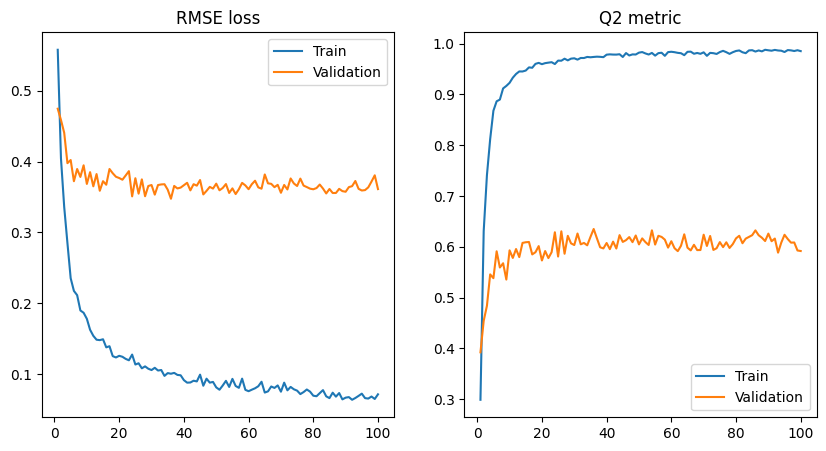

Best scores achieved:
On training set: Q2 0.97, RMSE 0.11
On test set: Q2 0.64, RMSE 0.37


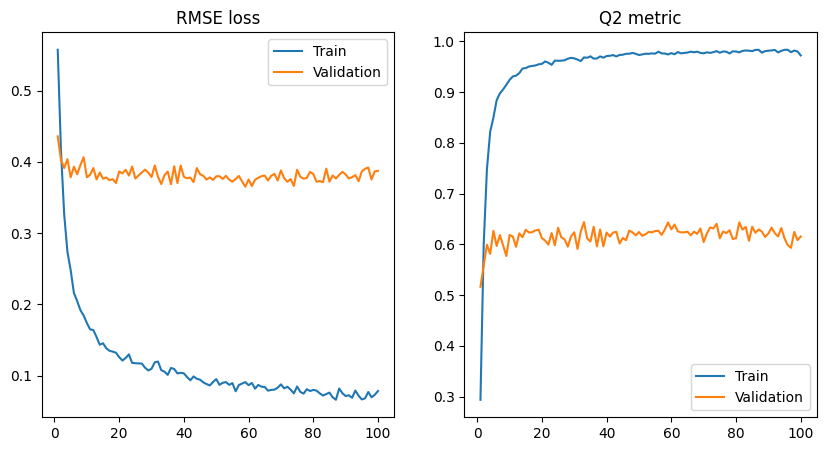

Best scores achieved:
On training set: Q2 0.96, RMSE 0.12
On test set: Q2 0.66, RMSE 0.38


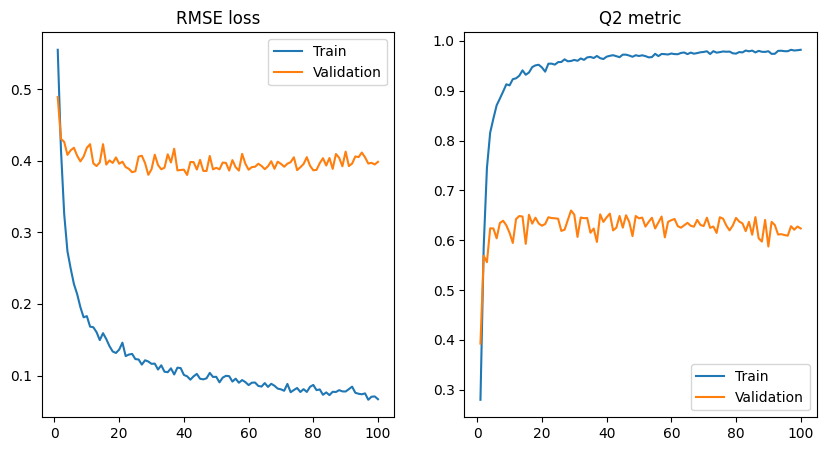

Best scores achieved:
On training set: Q2 0.98, RMSE 0.09
On test set: Q2 0.63, RMSE 0.38


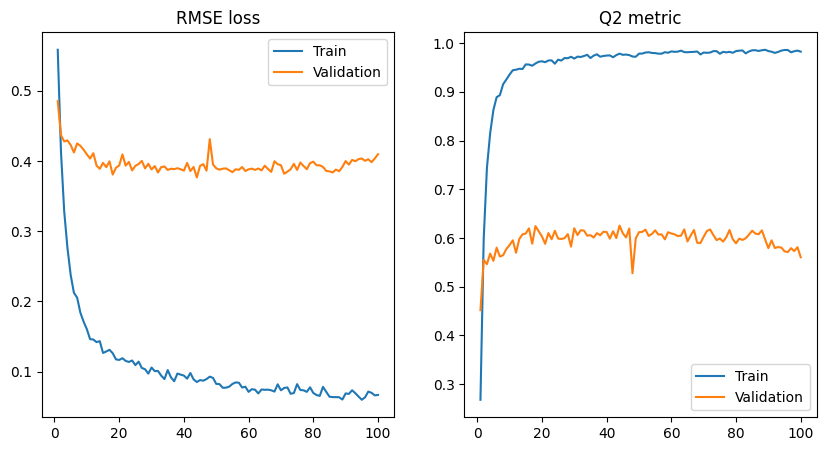

Best scores achieved:
On training set: Q2 0.97, RMSE 0.1
On test set: Q2 0.59, RMSE 0.39


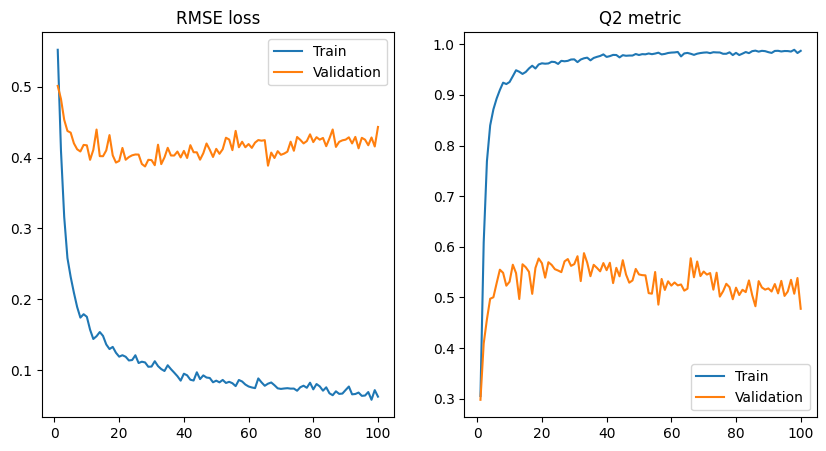

In [ ]:

for i, (train_index, val_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_test = y.iloc[train_index], y.iloc[val_index]
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

    scaler = StandardScaler().fit(X_train)
    X_train_sc = scaler.transform(X_train)
    X_test_sc = scaler.transform(X_test)

    # print(y_train)
    # initiate datasets
    train_data = logBBDataset(X_train_sc, y_train.to_numpy())
    test_data = logBBDataset(X_test_sc, y_test.to_numpy())

    trainloader = DataLoader(train_data, batch_size=10, shuffle=True)
    testloader = DataLoader(test_data, batch_size=10, shuffle=False)

    logBB_net, n_epochs, criterion, optimizer = initiate_model()
    # initiate trainer
    trainer = Trainer(logBB_net, n_epochs, criterion,
                  optimizer, trainloader, testloader,
                  DEVICE, r2_score, verbose=0)

    # train model
    trainer.fit()

    print("Best scores achieved:")
    print(f"On training set: Q2 {round(trainer.best_metrics[0][1], 2)}, RMSE {round(trainer.best_metrics[0][0], 2)}")
    print(f"On test set: Q2 {round(trainer.best_metrics[1][1], 2)}, RMSE {round(trainer.best_metrics[1][0], 2)}")
    q2_scores.append(round(trainer.best_metrics[1][1], 2))
    rmse_scores.append(round(trainer.best_metrics[1][0], 2))


    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes = axes.flatten()

    sns.lineplot(y=trainer.train_mse_losses, x=range(1, n_epochs + 1), label="Train", ax=axes[0])
    sns.lineplot(y=trainer.valid_mse_losses, x=range(1, n_epochs + 1), label="Validation", ax=axes[0])
    axes[0].set_title('RMSE loss')

    sns.lineplot(y=trainer.train_r2_metrics, x=range(1, n_epochs + 1), label="Train", ax=axes[1])
    sns.lineplot(y=trainer.valid_r2_metrics, x=range(1, n_epochs + 1), label="Validation", ax=axes[1])
    axes[1].set_title('Q2 metric')

    plt.show()



In [ ]:
np.mean(np.array(q2_scores))

0.6319999999999999

In [ ]:
np.std(np.array(q2_scores))

0.02315167380558047

In [ ]:
np.mean(np.array(rmse_scores))

0.374

In [ ]:
np.std(np.array(rmse_scores))

0.013564659966250548